## Imports

In [433]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

## Import Data

In [434]:
data_2015 = pd.read_csv('./data/2015.csv')
data_2016 = pd.read_csv('./data/2016.csv')
data_2017 = pd.read_csv('./data/2017.csv')
data_2018 = pd.read_csv('./data/2018.csv')
data_2019 = pd.read_csv('./data/2019.csv')

## Data Standardization

In [435]:
data_2015 = data_2015.rename(columns={
    "Happiness Rank": "Rank",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Life Expectancy",
    "Trust (Government Corruption)": "Trust"
})
data_2015 = data_2015.drop(columns=['Region', 'Standard Error', 'Family', 'Dystopia Residual'])

In [436]:
data_2016 = data_2016.rename(columns={
    "Happiness Rank": "Rank",
    "Happiness Score": "Score",
    "Economy (GDP per Capita)": "GDP per Capita",
    "Health (Life Expectancy)": "Life Expectancy",
    "Trust (Government Corruption)": "Trust"
})
data_2016 = data_2016.drop(columns=['Region', 'Lower Confidence Interval', 'Upper Confidence Interval', 'Family', 'Dystopia Residual'])

In [437]:
data_2017 = data_2017.rename(columns={
    "Happiness.Rank": "Rank",
    "Happiness.Score": "Score",
    "Economy..GDP.per.Capita.": "GDP per Capita",
    "Health..Life.Expectancy.": "Life Expectancy",
    "Freedom": "Freedom",
    "Generosity": "Generosity",
    "Trust..Government.Corruption.": "Trust"
})
data_2017 = data_2017.drop(columns=["Whisker.high", "Whisker.low", "Family", "Dystopia.Residual"])

In [438]:
data_2018 = data_2018.rename(columns={
    "Overall rank": "Rank",
    "Country or region": "Country",
    "GDP per capita": "GDP per Capita",
    "Healthy life expectancy": "Life Expectancy",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Trust"
})
data_2018 = data_2018.drop(columns=['Social support'])

In [439]:
data_2019 = data_2019.rename(columns={
    "Overall rank": "Rank",
    "Country or region": "Country",
    "GDP per capita": "GDP per Capita",
    "Healthy life expectancy": "Life Expectancy",
    "Freedom to make life choices": "Freedom",
    "Perceptions of corruption": "Trust"
})
data_2019 = data_2019.drop(columns=['Social support'])

Combine Dataframes

In [440]:
years = ["2015", "2016", "2017", "2018", "2019"]
data = [data_2015, data_2016, data_2017, data_2018, data_2019]
data_2015["Year"] = "2015"

all_df = data_2015.copy()
all_df["Year"] = "2015"
for index in range(1, len(data)):
    data[index]["Year"] = years[index]
    all_df = pd.concat([all_df, data[index]])

## Mean & Median Scores

<AxesSubplot:>

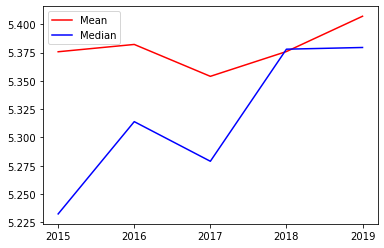

In [441]:

def mean_score(df):
    return df['Score'].mean()

def median_score(df):
    return df['Score'].median()

means = list(map(mean_score, data))
medians = list(map(median_score, data))

sns.lineplot(
    x=years,
    y=means,
    color="red",
    label="Mean"
)
sns.lineplot(
    x=years,
    y=medians,
    color="blue",
    label="Median"
)

## Stable Rankings

In [442]:
country_group = all_df.groupby(['Country'])
counts = country_group.count()["Year"].to_frame()
counts = counts.rename(columns={"Year": "Count"})
country_group = country_group.std()
country_group = country_group.merge(counts, how="inner", on=['Country'])

country_group = country_group[country_group["Count"] > 3]
country_score_std = country_group['Rank']
country_score_std.sort_values().head(10)

Country
New Zealand    0.447214
Australia      0.707107
Iceland        0.836660
Denmark        0.836660
Netherlands    0.836660
Costa Rica     0.894427
Sweden         1.140175
Belgium        1.140175
Austria        1.224745
Rwanda         1.224745
Name: Rank, dtype: float64

## Most Improved

In [443]:
rank_diff = data_2015.merge(data_2019, how="outer", on=['Country'])
rank_diff['Rank Diff'] = rank_diff['Rank_y'] - rank_diff['Rank_x']
rank_diff[['Country', 'Rank Diff']].sort_values(by='Rank Diff', ascending=False).head(10)

,Country,Rank Diff
22,Venezuela,85.0
84,Zambia,53.0
96,Lesotho,47.0
100,Swaziland,34.0
114,Zimbabwe,31.0
93,Mozambique,29.0
118,Haiti,28.0
115,Liberia,25.0
116,India,23.0
110,Ukraine,22.0


<AxesSubplot:xlabel='GDP per Capita', ylabel='Score'>

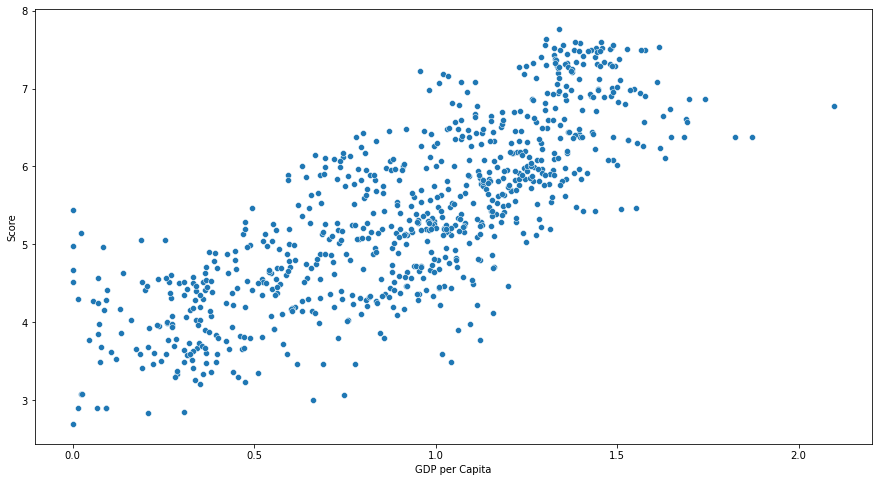

In [444]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data=all_df,
    x="GDP per Capita",
    y="Score"
)

<AxesSubplot:xlabel='Life Expectancy', ylabel='Score'>

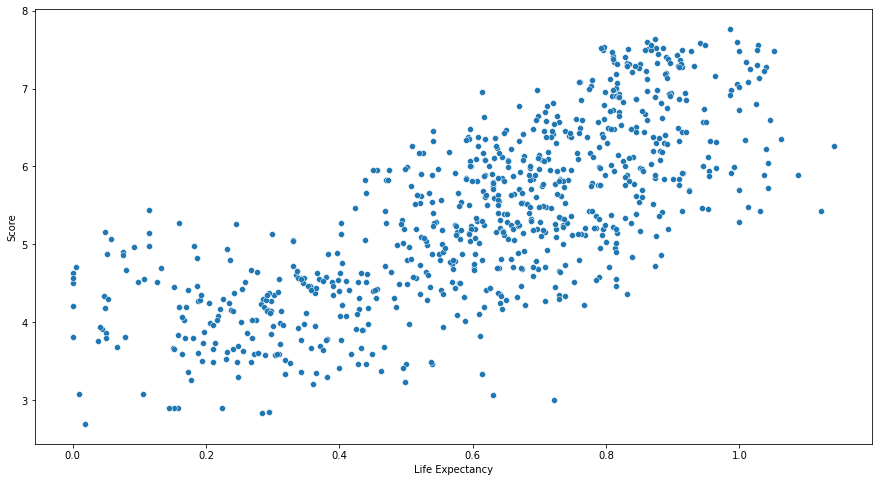

In [445]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data=all_df,
    x="Life Expectancy",
    y="Score"
)

<AxesSubplot:xlabel='Freedom', ylabel='Score'>

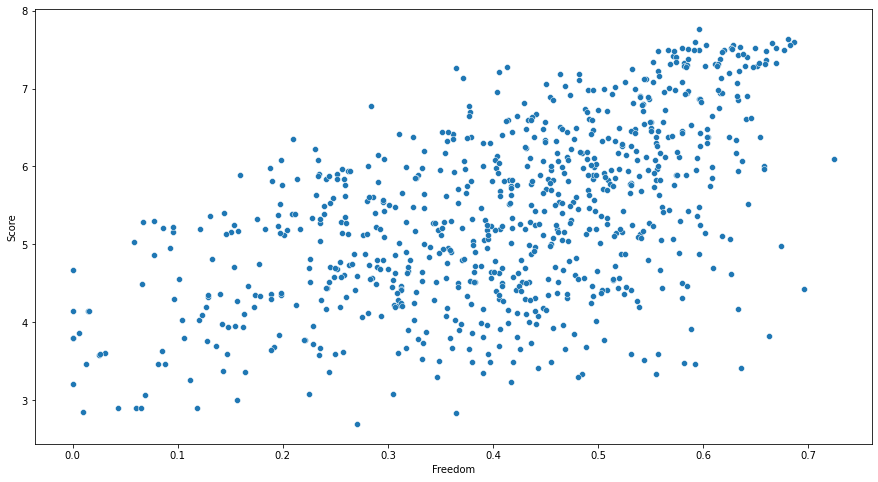

In [446]:
plt.figure(figsize=(15,8))
sns.scatterplot(
    data=all_df,
    x="Freedom",
    y="Score"
)

# Machine Learning
Separate Training and Actual Data

In [447]:
training_df = all_df[all_df["Year"] != "2019"]
x = training_df[['GDP per Capita', 'Life Expectancy', 'Freedom']]
y = training_df['Score']

test_x = data_2019[['GDP per Capita', 'Life Expectancy', 'Freedom']]
actual_score = data_2019['Score']
actual_rank = data_2019['Rank']

## Ordinary Least Square Linear Regression
Perform Linear Regression and assemble into DataFrame to compare predicted and actual score and rank

In [448]:
linear_reg = LinearRegression()
linear_reg.fit(x,y)
predicted_score = linear_reg.predict(test_x)

ret = pd.DataFrame({
    'Country': data_2019['Country'],
    'Predicted Score': predicted_score,
    'Actual Score': actual_score
})
ret["Predicted Rank"] = ret["Predicted Score"].rank(ascending=False)
ret.insert(4, "Actual Rank", actual_rank)
ret.sort_values(by='Predicted Rank', ascending=True)
ret['Delta'] = abs(ret["Predicted Score"] - ret['Actual Score'])
ret

,Country,Predicted Score,Actual Score,Predicted Rank,Actual Rank,Delta
0,Finland,6.816194,7.769,14.0,1,0.952806
1,Denmark,6.876640,7.600,8.0,2,0.723360
2,Norway,7.078632,7.554,2.0,3,0.475368
3,Iceland,6.907709,7.494,6.0,4,0.586291
4,Netherlands,6.821683,7.488,13.0,5,0.666317
...,...,...,...,...,...,...
151,Rwanda,4.972300,3.334,112.0,152,1.638300
152,Tanzania,4.685091,3.231,123.0,153,1.454091
153,Afghanistan,3.444446,3.203,154.0,154,0.241446
154,Central African Republic,3.187168,3.083,156.0,155,0.104168


Calculate Root Mean Squared Error

In [449]:
rmse = mean_squared_error(actual_score, predicted_score, squared=False)
rmse

0.5684611949933855

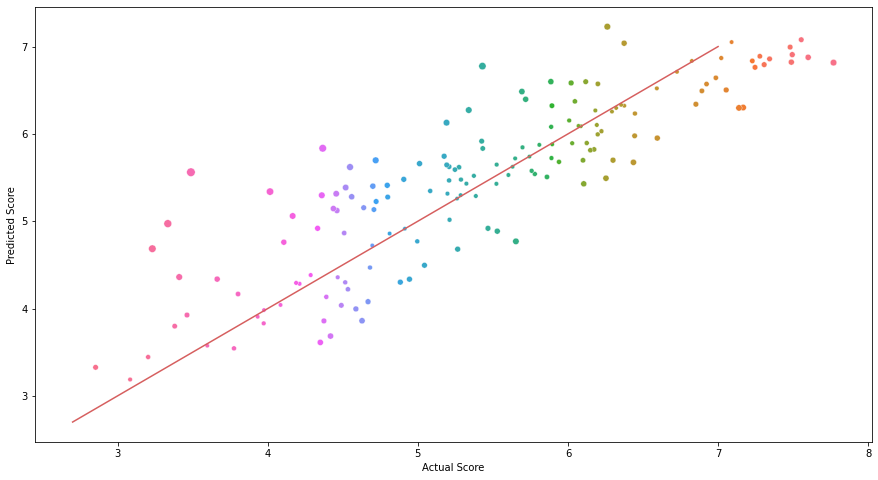

In [450]:
X_plot = np.linspace(2.7, 7, 100)
Y_plot = X_plot

plt.figure(figsize=(15,8))
p = sns.scatterplot(
    data=ret,
    x="Actual Score",
    y="Predicted Score",
    hue="Country",
    size="Delta"
)
p.legend_.remove()

plt.plot(X_plot, Y_plot, color='r')
plt.show()

## K-Nearest Neighbors Regression
The K-Nearest Neighbors Regression uses the k nearest points and averages them to predict.
Use k=5

In [451]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x, y)
knn_predicted_score = knn.predict(test_x)

knn_ret = pd.DataFrame({
    'Country': data_2019['Country'],
    'Predicted Score': knn_predicted_score,
    'Actual Score': actual_score
})
knn_ret["Predicted Rank"] = knn_ret["Predicted Score"].rank(ascending=False)
knn_ret.insert(4, "Actual Rank", actual_rank)
knn_ret.sort_values(by='Predicted Rank', ascending=True)
knn_ret['Delta'] = abs(knn_ret["Predicted Score"] - knn_ret['Actual Score'])
knn_ret

,Country,Predicted Score,Actual Score,Predicted Rank,Actual Rank,Delta
0,Finland,6.5618,7.769,7.0,1,1.2072
1,Denmark,6.3380,7.600,18.0,2,1.2620
2,Norway,6.1982,7.554,30.0,3,1.3558
3,Iceland,6.3934,7.494,13.5,4,1.1006
4,Netherlands,6.0652,7.488,32.0,5,1.4228
...,...,...,...,...,...,...
151,Rwanda,4.6930,3.334,122.0,152,1.3590
152,Tanzania,4.8870,3.231,114.0,153,1.6560
153,Afghanistan,3.7080,3.203,155.0,154,0.5050
154,Central African Republic,3.7690,3.083,150.0,155,0.6860


In [452]:
knn_rmse = mean_squared_error(actual_score, knn_predicted_score, squared=False)
knn_rmse

0.6869988730912392

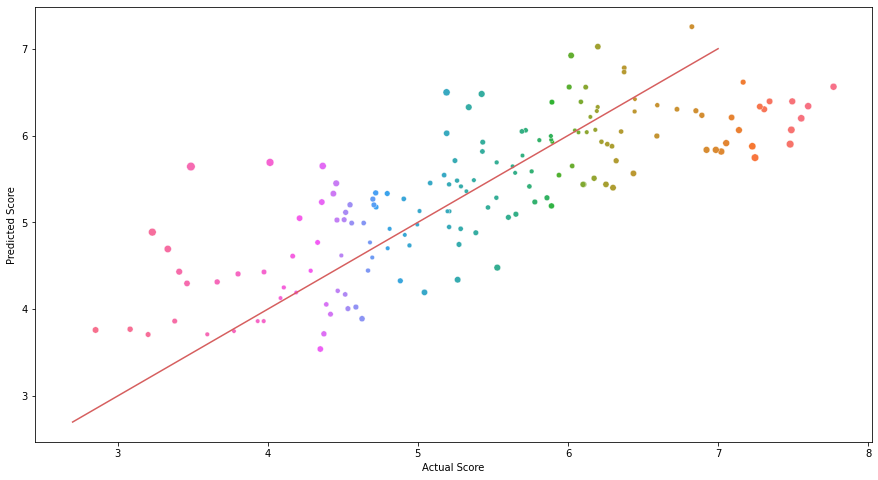

In [453]:
X_plot = np.linspace(2.7, 7, 100)
Y_plot = X_plot

plt.figure(figsize=(15,8))
p = sns.scatterplot(
    data=knn_ret,
    x="Actual Score",
    y="Predicted Score",
    hue="Country",
    size="Delta"
)
p.legend_.remove()

plt.plot(X_plot, Y_plot, color='r')
plt.show()

## Stochastic Gradient Descent

In [454]:
grad_descent = SGDRegressor()
grad_descent.fit(x, y)
grad_predicted_score = grad_descent.predict(test_x)

grad_ret = pd.DataFrame({
    'Country': data_2019['Country'],
    'Predicted Score': grad_predicted_score,
    'Actual Score': actual_score
})
grad_ret["Predicted Rank"] = grad_ret["Predicted Score"].rank(ascending=False)
grad_ret.insert(4, "Actual Rank", actual_rank)
grad_ret.sort_values(by='Predicted Rank', ascending=True)
grad_ret['Delta'] = abs(grad_ret["Predicted Score"] - grad_ret['Actual Score'])
grad_ret

,Country,Predicted Score,Actual Score,Predicted Rank,Actual Rank,Delta
0,Finland,6.747132,7.769,16.0,1,1.021868
1,Denmark,6.823112,7.600,10.0,2,0.776888
2,Norway,7.045404,7.554,4.0,3,0.508596
3,Iceland,6.852802,7.494,8.0,4,0.641198
4,Netherlands,6.800986,7.488,14.0,5,0.687014
...,...,...,...,...,...,...
151,Rwanda,4.665370,3.334,121.0,152,1.331370
152,Tanzania,4.532563,3.231,124.0,153,1.301563
153,Afghanistan,3.608182,3.203,152.0,154,0.405182
154,Central African Republic,3.079624,3.083,156.0,155,0.003376


In [455]:
grad_rmse = mean_squared_error(actual_score, grad_predicted_score, squared=False)
grad_rmse

0.5838596939899446

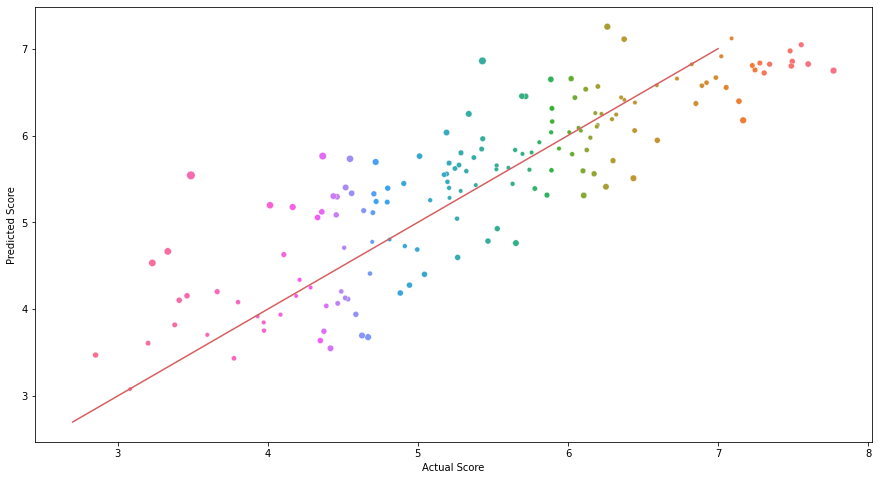

In [456]:
X_plot = np.linspace(2.7, 7, 100)
Y_plot = X_plot

plt.figure(figsize=(15,8))
p = sns.scatterplot(
    data=grad_ret,
    x="Actual Score",
    y="Predicted Score",
    hue="Country",
    size="Delta"
)
p.legend_.remove()

plt.plot(X_plot, Y_plot, color='r')
plt.show()

## Algorithm Analysis
The Least-Square Regression and Stochastic Gradient Regression performed comparatively well, with the Least-Square Regression performing marginally better as seen by the Root Mean Squared Error. The K-Nearest Neighbors Regression performed a fair bit worse than the other two.